# Определение неэффективных операторов провайдера "Нупозвони"

Презентация https://docs.google.com/presentation/d/1a09bE_LKrfrtTsLLfptNifmCuun_sDqS9woCNu_av5Y/edit?usp=sharing

Дашборд: https://public.tableau.com/views/telecom_calls_count/Dashboard1?:language=en-US&publish=yes&:display_count=n&:origin=viz_share_link

**Описание проекта:**

 Мы работаем в провайдере "Нупозвони". Нашими клиентами являются кол-центры, которые осуществляют обзвон своих клиентов и принимают входящие вызовы от них. В каждом кол центре работают несколько операторов. Сейчас мы разрабатываем новую функциональность, которая позволит кол-центрам определять неэффективных операторов.

**Цель проекта:** научится определять неэффективных операторов

**Задачи проекта:**
- проанализировать имеющиеся данные,
- изучить индустриальные стандарты по эффективности операторов кол центров
- выявить неэффективных операторов по разным критриям
- выявить у каких клиентов много неэффективных операторов

## Импортируем необходимые библиотеки, загрузим данные

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import math as mth
import matplotlib.pyplot as plt
from scipy import stats as st
from pandas.core.groupby import groupby
import scipy.stats as stats
from statsmodels.stats.weightstats import ztest as ztest

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
tel_data.sample(10)

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
33236,167487,2019-10-18 00:00:00+03:00,out,False,914052.0,True,21,0,404
6919,166582,2019-09-22 00:00:00+03:00,out,False,885876.0,True,57,0,1976
4193,166503,2019-10-21 00:00:00+03:00,out,False,906680.0,False,3,307,353
13036,166782,2019-10-09 00:00:00+03:00,in,False,893804.0,False,31,1833,1960
47861,168187,2019-10-30 00:00:00+03:00,in,False,937736.0,True,1,0,20
29580,167246,2019-11-01 00:00:00+03:00,out,False,908078.0,False,6,239,278
32217,167455,2019-10-24 00:00:00+03:00,out,False,918390.0,False,2,1869,1895
44040,168021,2019-11-12 00:00:00+03:00,out,False,939218.0,True,6,0,95
49468,168187,2019-11-26 00:00:00+03:00,out,False,937902.0,True,26,0,681
28354,167180,2019-10-16 00:00:00+03:00,in,False,905932.0,False,1,28,34


## Откроем таблицы и изучим общую информацию о данных

In [ ]:
tel_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              53902 non-null  int64  
 1   date                 53902 non-null  object 
 2   direction            53902 non-null  object 
 3   internal             53785 non-null  object 
 4   operator_id          45730 non-null  float64
 5   is_missed_call       53902 non-null  bool   
 6   calls_count          53902 non-null  int64  
 7   call_duration        53902 non-null  int64  
 8   total_call_duration  53902 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.3+ MB


Согласно документации: 

user_id — Идентификатор клиентского аккаунта в сервисе

date — Дата статистики

direction — Направление вызовов (out - исходящий вызов, in — входящий
вызов)

internal — Является ли звонок внутренним звонком между операторами 
клиента

operator_id — Идентификатор оператора

is_missed_call — Является ли звонок пропущенным

calls_count — Количество звонков

call_duration — Длительность звонка (без учета времени ожидания)

total_call_duration — Длительность звонка (с учетом времени ожидания)

Мы видим 53902 записи в большинстве колонок. Больше всего пропусков в колонке operator_id, также немного в колонке internal. 

Типы данных:

- в колонке с датой нужно заменить на фотмат datetime, 
 
- direction удобней будет пользоваться, если мы заменим текст на обозначения 0/1, 0 - исходящие звонки, 1 - входящие звонки

- operator_id заменить на тип int


In [ ]:
round(tel_data.describe(), 2) 

,user_id,operator_id,calls_count,call_duration,total_call_duration
count,53902.00,45730.00,53902.00,53902.00,53902.00
mean,167295.34,916535.99,16.45,866.68,1157.13
std,598.88,21254.12,62.92,3731.79,4403.47
min,166377.00,879896.00,1.00,0.00,0.00
25%,166782.00,900788.00,1.00,0.00,47.00
50%,167162.00,913938.00,4.00,38.00,210.00
75%,167819.00,937708.00,12.00,572.00,902.00
max,168606.00,973286.00,4817.00,144395.00,166155.00


In [ ]:
tel_data['date'].min()

'2019-08-02 00:00:00+03:00'

In [ ]:
tel_data['date'].max()

'2019-11-28 00:00:00+03:00'

У нас есть данные с 2 августа 2019 года по 28 ноября 2019 года.

In [ ]:
tel_cl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      732 non-null    int64 
 1   tariff_plan  732 non-null    object
 2   date_start   732 non-null    object
dtypes: int64(1), object(2)
memory usage: 17.3+ KB


In [ ]:
tel_cl.head()

,user_id,tariff_plan,date_start
0,166713,A,2019-08-15
1,166901,A,2019-08-23
2,168527,A,2019-10-29
3,167097,A,2019-09-01
4,168193,A,2019-10-16


In [ ]:
tel_cl.date_start.min()

'2019-08-01'

In [ ]:
tel_cl.date_start.max()

'2019-10-31'

В таблице с тарифами пропусков нет, данные с 1 августа по 31 октября. Столбец с датой необходимо перевести в формат datatime

**Вывод по разделу**

У нас есть данные для каждого оператора, который работает на какого-либо из наших клиетов сформированные по дням и типам звонков.

Данные с 1 августа по 31 октября 2019 года, всего 53902 строк. 

Также есть данные о тарифе клиента и дате его подключения.

Предварительно можно утверждать, что, данных достаточно для ответа на поставленные вопросы. Но встречаются пропуски в данных, в столбцах с идентификатором оператора и направлением звонков. 

Типы столбцов с датами не соответсвуют типу данных.
 

## Предобработка данных

### Изменим тип данных в столбцах. 

В столбце дата у нас указано время и часовой пояс, но они все одинаковые. Уберем эту часть, оставим только дату и переведем ее в тип данных datetime

In [ ]:
tel_data['date'] = tel_data['date'].str.split(' ').str[0]

tel_data['date'] = pd.to_datetime(tel_data['date'], format='%Y-%m-%d')

In [ ]:
tel_cl['date_start'] = pd.to_datetime(tel_cl['date_start'], format='%Y-%m-%d')

Заменим строковые значения, на цифровые обозначения и приведем к типу int колонку direction

In [ ]:
tel_data['direction'] = tel_data['direction'].replace('out', 0)

In [ ]:
tel_data['direction'] = tel_data['direction'].replace('in', 1)

In [ ]:
tel_data['direction'] = tel_data['direction'].astype('int8')
tel_data['direction'].unique()

array([1, 0], dtype=int8)

### Обработаем пропущенные значения

Изучим пропущенные данные в столбце оператор

In [ ]:
tel_nul = tel_data[tel_data['operator_id'].isnull() == True]
tel_nul.sample(10)

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
13742,166800,2019-11-15,1,False,NaN,True,2,0,36
30137,167285,2019-10-09,0,False,NaN,True,2,0,0
22718,167071,2019-10-05,1,False,NaN,True,20,0,712
27083,167172,2019-11-01,1,False,NaN,True,3,0,127
28060,167176,2019-11-12,1,False,NaN,True,3,0,312
37956,167650,2019-09-26,1,False,NaN,True,2,0,35
41909,167906,2019-10-07,1,False,NaN,True,1,0,0
39053,167664,2019-10-27,1,False,NaN,True,2,0,4
5889,166536,2019-10-22,1,False,NaN,True,2,0,95
21900,167052,2019-10-05,1,False,NaN,True,14,0,147


In [ ]:
tel_nul.groupby('user_id').agg({'calls_count':'count'}).sort_values(by='calls_count', ascending=False).head(10)

,calls_count
user_id,
168252,145
166405,122
166582,118
166782,117
166658,111
166983,96
166916,92
166541,89
166485,89


Как мы видим почти всегда это пропущенные входящие звонки. Проверим долю входящих и долю пропущенных звонков в этой выборке

In [ ]:
tel_nul['is_missed_call'].mean()

0.9850709740577582

In [ ]:
tel_nul['direction'].mean()

0.9755261869799314

Мы видим, что из этих 8 тыс строк 98% пропущенные вызовы и 97% входящие. 

Вероятнее всего это вызовы в кол-центрах в нерабочее время, которые не относятся никакому оператору и не должны были быть обработаны. 

Логично будет их не брать в исследование, чтобы они не влияли на общую статистику по клиентам и операторам.

Удалим строки в которых оператор не установлен

In [ ]:
tel_data.dropna(subset = ['operator_id'], inplace=True)

In [ ]:
tel_data['operator_id'] = tel_data['operator_id'].astype('int64')

In [ ]:
tel_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45730 entries, 1 to 53900
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   user_id              45730 non-null  int64         
 1   date                 45730 non-null  datetime64[ns]
 2   direction            45730 non-null  int8          
 3   internal             45670 non-null  object        
 4   operator_id          45730 non-null  int64         
 5   is_missed_call       45730 non-null  bool          
 6   calls_count          45730 non-null  int64         
 7   call_duration        45730 non-null  int64         
 8   total_call_duration  45730 non-null  int64         
dtypes: bool(1), datetime64[ns](1), int64(5), int8(1), object(1)
memory usage: 2.9+ MB


Остались еще пропуски в столбце internal. Выведем несколько строк с пропущенными значениями

In [ ]:
tel_data[tel_data['internal'].isnull() == True]

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
1924,166406,2019-09-02,1,NaN,879898,False,1,2,9
6210,166541,2019-09-26,1,NaN,908960,False,1,393,423
6216,166541,2019-09-26,1,NaN,908958,False,2,547,612
7528,166604,2019-11-01,1,NaN,893402,False,1,94,117
8650,166658,2019-09-24,1,NaN,890404,False,1,150,157
9080,166658,2019-10-15,1,NaN,890404,False,1,51,57
16180,166916,2019-10-01,1,NaN,906396,False,1,100,117
16304,166916,2019-10-07,1,NaN,906406,False,3,378,461
16569,166916,2019-10-23,1,NaN,906400,False,1,81,110
18647,166983,2019-09-02,1,NaN,901880,False,1,119,127


Выглядят как обычные звонки, не пропущенные, есть продолжительность и ожидание. Их не много, но терять данные не хочется. 

Мы выяснили, что внутренние и внешние звонки одинаково важны для статистики, т.к. в любом случае на другом конце провода клиент, внутренние это звонки, когда один оператор переключает на другого. 

Заменим их на внутренние звонки, возможно сбой в определении откуда звонок происходит при переключении между линиями. 

In [ ]:
tel_data['internal'] = tel_data['internal'].fillna(1)


### Проверим явные дубликаты

In [ ]:
tel_data.duplicated().sum()

4184

In [ ]:
tel_data[tel_data.duplicated(keep=False)]

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
6,166377,2019-08-05,0,False,880020,True,8,0,50
8,166377,2019-08-05,0,False,880020,True,8,0,50
43,166377,2019-08-14,0,False,880026,False,10,1567,1654
44,166377,2019-08-14,0,False,880026,False,10,1567,1654
46,166377,2019-08-15,0,False,880026,False,11,1413,1473
...,...,...,...,...,...,...,...,...,...
53874,168601,2019-11-26,1,False,952914,False,4,539,562
53883,168603,2019-11-20,0,False,959118,True,3,0,89
53885,168603,2019-11-20,0,False,959118,True,3,0,89
53899,168606,2019-11-15,0,True,957922,False,4,3130,3190


Это полные дубликаты, информация в строках разная: входящие, исходящие, пропущенные и нет, разные клиенты, разные операторы. По какой-то причине в базе задвоились 4184 строки. 

Удалим эти дубликаты

In [ ]:
tel_data = tel_data.drop_duplicates()

In [ ]:
tel_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41546 entries, 1 to 53899
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   user_id              41546 non-null  int64         
 1   date                 41546 non-null  datetime64[ns]
 2   direction            41546 non-null  int8          
 3   internal             41546 non-null  object        
 4   operator_id          41546 non-null  int64         
 5   is_missed_call       41546 non-null  bool          
 6   calls_count          41546 non-null  int64         
 7   call_duration        41546 non-null  int64         
 8   total_call_duration  41546 non-null  int64         
dtypes: bool(1), datetime64[ns](1), int64(5), int8(1), object(1)
memory usage: 2.6+ MB


### Исследуем данные на аномалии

In [ ]:
tel_data.describe()

,user_id,direction,operator_id,calls_count,call_duration,total_call_duration
count,41546.000000,41546.000000,41546.000000,41546.000000,41546.000000,41546.000000
mean,167301.311992,0.306480,916523.315409,16.900424,1009.769172,1321.592813
std,600.418838,0.461037,21230.041008,59.749373,4064.106117,4785.978633
min,166377.000000,0.000000,879896.000000,1.000000,0.000000,0.000000
25%,166782.000000,0.000000,900790.500000,1.000000,0.000000,67.000000
50%,167175.000000,0.000000,913938.000000,4.000000,106.000000,288.000000
75%,167827.000000,1.000000,937708.000000,13.000000,770.000000,1104.000000
max,168606.000000,1.000000,973286.000000,4817.000000,144395.000000,166155.000000


Вызывает сомнение самое большое количество звонков 4817, которое совершил какой-то оператор. 

In [ ]:
tel_data.query('calls_count == 4817')

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
40733,167827,2019-11-11,0,False,929428,True,4817,0,5529


Это были исходящие звонки, продолжительность разговора по ним 0, общая продолжительность 5529. Если считать, что время измеряется в минутах, то это 92 часа. Такого не может быть в рамках 1 суток, знгачит время измеряется в данном файле в секундах. Значит время ожидания по каждому звонку 1-2 секунды. Скорее всего это накручено какой-то программой, которая набирала номер и сбрасывала его. Нужно сообщить клиенту о таком операторе похоже на мошенничество, особенно если оплата у оператора проходит по количеству совершенных звонков. 

В целом если предположить, что рабочий день у операторов не больше 12 часов, то больше 1440 звонков (2 звонка в минуту) совершить мало вероятно, посмотрим есть ли еще такие операторы

In [ ]:
tel_data.query('calls_count > 1440')

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
6984,166582,2019-10-01,0,False,885876,False,1480,86910,113843
40671,167827,2019-10-31,0,False,929428,True,2614,0,45312
40680,167827,2019-11-01,0,False,929428,True,1529,0,28017
40690,167827,2019-11-05,0,False,929428,True,1533,0,27889
40733,167827,2019-11-11,0,False,929428,True,4817,0,5529


У этого же оператора есть еще 3 таких дня с большим количеством звонков с нулевой продолжительностью разговора. 

Также есть оператор 885876, у него звонки похожи на настоящие, их чуть больше 1440, но есть продолжительность разговора, в среднем 58 секунд на звонок. 

Посмотрим на другие дни оператора 929428

In [ ]:
tel_data.query('operator_id == 929428').sort_values(by='calls_count', ascending = False).head(20)

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
40733,167827,2019-11-11,0,False,929428,True,4817,0,5529
40671,167827,2019-10-31,0,False,929428,True,2614,0,45312
40690,167827,2019-11-05,0,False,929428,True,1533,0,27889
40680,167827,2019-11-01,0,False,929428,True,1529,0,28017
40708,167827,2019-11-07,0,False,929428,True,1365,0,24450
40701,167827,2019-11-06,0,False,929428,True,1045,0,18978
40718,167827,2019-11-08,0,False,929428,True,685,0,12423
40656,167827,2019-10-29,0,False,929428,True,593,0,10177
40661,167827,2019-10-30,0,False,929428,True,437,0,8370
40646,167827,2019-10-28,0,False,929428,True,383,0,8752


17 дней у оператора такие же, много звонков с 0 временем разговора. Правда ожидание уже побольше. 

In [ ]:
tel_data.query('user_id == 167827')['operator_id'].unique()

array([929424, 929426, 929428])

У этого клиента не один оператор, есть еще 2. 

In [ ]:
tel_data.query('operator_id == 929424').sort_values(by='calls_count', ascending = False).head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
40520,167827,2019-10-10,0,False,929424,False,970,41344,52466
40527,167827,2019-10-11,0,False,929424,False,538,26153,32481
40523,167827,2019-10-11,0,False,929424,True,498,0,9794
40514,167827,2019-10-10,0,False,929424,True,495,0,10489
40546,167827,2019-10-14,0,False,929424,True,252,0,5387


In [ ]:
tel_data.query('operator_id == 929426').sort_values(by='calls_count', ascending = False).head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
40792,167827,2019-11-22,0,False,929426,True,1020,0,16942
40521,167827,2019-10-11,0,False,929426,False,570,22503,29276
40784,167827,2019-11-21,0,False,929426,True,507,0,8475
40825,167827,2019-11-27,0,False,929426,True,499,0,11784
40820,167827,2019-11-27,0,False,929426,False,441,20560,28432


Удалять эти данные не будем, порекомендуем сообщить о нем клиенту

Сделаем срез по пропущенным звонкам, есть ли среди них звонки с продолжительностью разговора  > 1 (одна секунда это сброс звонка и тогда он считается пропущенным)

In [ ]:
tel_data.query('is_missed_call == True and call_duration > 1')

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
1606,166405,2019-11-19,1,False,939478,True,1,165,173
2283,166407,2019-09-23,1,False,888534,True,1,133,156
2956,166485,2019-09-09,1,False,887276,True,1,31,44
3376,166485,2019-10-31,1,False,887276,True,1,79,123
3975,166503,2019-08-12,1,True,884408,True,1,38,69
...,...,...,...,...,...,...,...,...,...
51488,168307,2019-10-30,1,False,945052,True,2,56,70
51577,168336,2019-10-30,1,False,948756,True,1,50,58
51664,168336,2019-11-12,1,False,947304,True,1,69,72
51693,168336,2019-11-15,1,False,947304,True,1,46,49


192 таких звонков, не понятно почему эти звонки отмечены как пропущенные, возможно разговора не было, а в это время попала запись автоответчика.

**Вывод по разделу:**

Мы провели предобработку данных:
- изменили типы данных,
- преобразовали данные в более удобный формат,
- обработали пропущенные значения,
- удалили дубликаты
- выявили аномальные значения

В целом данные собираются правильно, но есть несколько проблем:


1.   Пропуски в столбце с оператором.  Они вероятне всего возникли из-за звонков, когда оператооров нет на линии и звонок не прикреплялся к конкретному оператору. У нас есть id клиетов у которых много таких звонков, думаю для них это важная информация. У клиентов 168252, 166405, 166582, 166782, 166658 более 100 таких пропущенных звонков
2.   Дубликатов 9,15% от всех данных. Нужно выяснить по какой причине почти 10% данных задвоилось в базе, возможно при агрегировании по датам, клиентам или при слиянии из разных баз. Возможно ли, что под одним оператором работате несколько человек?
3. У клиента 167827 есть оператор с аномально большим количеством звонков, возможно использует для прозвона какие-то программы.
4. Также есть звонки, которые в базе отмечены как пропущенные, но по которым продолжительность разговора больше 1 сек. Не понятно где ошибка, в обозначении, что они пропущенны или в том, что во время звонка попадают, например, сообщения автоатветчика?

## Исследовательский анализ данных

### Категоризация клиентов

In [ ]:
tel_data.user_id.nunique()

290

Уникальных клиентов у нас 290

In [ ]:
tel_data.operator_id.nunique()

1092

Уникальных операторов - 1092

#### Категоризация по количеству операторов

Проверим как распределяются операторы по клиентам. 

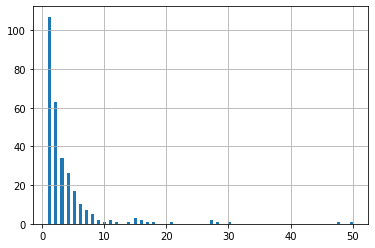

In [ ]:
user_tel = tel_data.groupby('user_id').agg({'operator_id':'nunique'}).reset_index()
user_tel.operator_id.hist(bins=100)

Видно по графику, что у нас преобладают небольшие компании, в которых 1-4 оператора. 

In [ ]:
user_tel.query('operator_id > 4').count()

user_id        60
operator_id    60
dtype: int64

Больше 4 операторов только у 60 клиентов. Это примерно 20% от общего числа. Таким образом, деление на крупные и мелкие кол центры образует не равные группы.



#### Категоризация по тарифам

Объединим таблицы по user_id

In [ ]:
tel = pd.merge(tel_data, tel_cl, how='left')

In [ ]:
tel.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41546 entries, 0 to 41545
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   user_id              41546 non-null  int64         
 1   date                 41546 non-null  datetime64[ns]
 2   direction            41546 non-null  int8          
 3   internal             41546 non-null  object        
 4   operator_id          41546 non-null  int64         
 5   is_missed_call       41546 non-null  bool          
 6   calls_count          41546 non-null  int64         
 7   call_duration        41546 non-null  int64         
 8   total_call_duration  41546 non-null  int64         
 9   tariff_plan          41546 non-null  object        
 10  date_start           41546 non-null  datetime64[ns]
dtypes: bool(1), datetime64[ns](2), int64(5), int8(1), object(2)
memory usage: 3.2+ MB


In [ ]:
tel.sample(5)

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,tariff_plan,date_start
25340,167487,2019-10-13,0,False,914240,True,9,0,101,B,2019-09-18
11573,166896,2019-11-11,1,False,895574,False,1,192,207,A,2019-08-23
13855,166974,2019-09-05,0,False,900354,True,3,0,50,C,2019-08-27
2833,166485,2019-11-22,0,False,907174,True,12,0,264,B,2019-08-06
21059,167176,2019-09-13,1,False,907952,False,1,48,66,B,2019-09-05


In [ ]:
user_tar = tel.groupby('tariff_plan').agg({'user_id':'nunique'})
user_tar

,user_id
tariff_plan,
A,32
B,101
C,157


По параметру тариф все клиенты распределяются также неравномерно, клиетов тарифа С больше, чем остальных

#### Категоризация по специализации (обзвоны или прием звонков)

Сформируем сводную таблицу, в которой будет видно долю исходящих звонков. 

In [ ]:
tel_dir = pd.pivot_table(tel, index=['user_id'],columns=['direction'],
               values=['calls_count'], aggfunc=['sum'],fill_value=0)

tel_dir['date'] = pd.pivot_table(tel, index=['user_id'],
               values=['date'], aggfunc=['nunique'])

tel_dir.reset_index()

tel_dir.columns= [ 'out', 'in', 'days']
tel_dir['percent_out'] = round(tel_dir['out']/(tel_dir['out'] + tel_dir['in']) * 100)

tel_dir.head()

,out,in,days,percent_out
user_id,,,,
166377,4952,102,83,98.0
166391,1,6,4,14.0
166392,0,102,41,0.0
166399,0,11,9,0.0
166405,9825,2191,97,82.0


Выберем клиентов, которые специализируются на обзвонах. Соответсвенно доля исходящих звонков у них должна быть  50% Или больше

In [ ]:
tel_out = tel_dir.query('percent_out > 49')
tel_out.sort_values(by = 'percent_out')

,out,in,days,percent_out
user_id,,,,
167113,1,1,1,50.0
167543,9,9,9,50.0
167263,8,8,9,50.0
168500,2,2,3,50.0
167246,77,74,42,51.0
...,...,...,...,...
167645,679,0,12,100.0
167716,733,0,52,100.0
168018,12325,0,25,100.0


Добавим 

In [ ]:
tel_in = tel_dir.query('percent_out < 50')
tel_in.sort_values(by = 'percent_out')

,out,in,days,percent_out
user_id,,,,
168598,0,22,10,0.0
167474,0,5,3,0.0
167402,0,144,49,0.0
167286,0,168,58,0.0
167277,0,11,8,0.0
...,...,...,...,...
168275,110,141,17,44.0
167969,47,58,14,45.0
167977,971,1110,37,47.0


Группы получились примерно равные по количеству

Конечно, клиентов с 50% исходящих звонков трудно считать специализирующимися на обзвонах, но это нужно нам для анализа имеющейся информации. 

В дальнейшем будет создан дашборд, в котором клиенты сами смогут определять какие признаки эффективности своих операторов они хотят выбрать и какие пороги эффективности установить.

**Выводы по разделу:** мы использовали три различных вида категоризации клиентов. Примерно равные группы получились при распределении по специализации

### Изучим количество пропущенных входящих вызовов и определим неэффективных операторов 

Показатель CAR: call abandonment rate — показатель необработанных вызовов.  Он измеряет количество звонков, во время которых клиент положил трубку, не дождавшись ответа. Индустриальный стандарт — 5–8 % (Источник: https://www.cossa.ru/special/business-processes/276786/?ysclid=l4jt0sf2on196552777) 

Расчитаем CAR для наших данных

Сделаем срез данных, в котором будут только входящие звонки

In [ ]:
operator_in = tel.query('direction == 1')

Сформируем сводную таблицу, в которой будут сгрупированы данные по операторам и посчитаны входящие звонки, пропущенные и нет

In [ ]:
operator_car = pd.pivot_table(operator_in, index=['operator_id'],columns=['is_missed_call'],
               values=['calls_count'], aggfunc=['sum'],fill_value=0).reset_index()

operator_car.head()

operator_id         sum     
                           calls_count     
is_missed_call                   False True
0                   879896          58    0
1                   879898         104    0
2                   880020           7    0
3                   880022           8    0
4                   880026          24    0

Переименуем колонки и добавим колонку с процентом пропущенных вызовов от всех входящих у данного оператора

In [ ]:
operator_car.columns= ['operator_id', 'received', 'missed']
operator_car['percent_missed'] = round(operator_car['missed']/(operator_car['received'] + operator_car['missed']) * 100)
operator_car.sample(5)

,operator_id,received,missed,percent_missed
131,900458,1,0,0.0
276,911214,2,0,0.0
519,937862,122,0,0.0
507,937762,95,1,1.0
299,914636,3,0,0.0


Построим график распределения процентного соотношения пропущенных вызовов

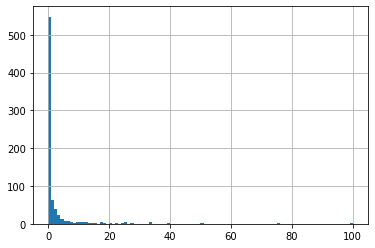

In [ ]:
operator_car.percent_missed.hist(bins=100);

У большей части операторов этот процент равен 0. Посмотрим сколько операторов являтся неэффективными при пороге 8% 

In [ ]:
operator_car_8 = operator_car.query('percent_missed > 8') 
operator_car_8.operator_id.count() 

43

Посмотрим сколько операторов являтся неэффективными при пороге 5%

In [ ]:
operator_car_5 = operator_car.query('percent_missed > 5')
operator_car_5.operator_id.count() 

60

Таким образом мы выявили неэффективных операторов по первому критерию: много пропущенных входящих звонков, предлагаю взять порог 5%, так мы сможем большему количеству клиентов показать, что у них есть операторы, которые пропускают довольно большое количество звонков. В дальнейшем же сам клиент сможет устанавливать порог значений, который будет для него являтся показательным. 

Чтобы в дашборде, в котором будет возможность отфильтровывать для клиента его неэффективных операторов (по тем порогам, которые он сам задаст), нужно добавить колонку с процентом пропущенных вызовов в основной датасет.

In [ ]:
tel = tel.merge(operator_car, on=["operator_id"], how='left')
tel.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,tariff_plan,date_start,received,missed,percent_missed
0,166377,2019-08-05,0,True,880022,True,3,0,5,B,2019-08-01,8.0,0.0,0.0
1,166377,2019-08-05,0,True,880020,True,1,0,1,B,2019-08-01,7.0,0.0,0.0
2,166377,2019-08-05,0,True,880020,False,1,10,18,B,2019-08-01,7.0,0.0,0.0
3,166377,2019-08-05,0,False,880022,True,3,0,25,B,2019-08-01,8.0,0.0,0.0
4,166377,2019-08-05,0,False,880020,False,2,3,29,B,2019-08-01,7.0,0.0,0.0


### Изучим среднее время ожидания ответа при входящих внешних вызовах

Параметр SL: service level — уровень обслуживания. 

Традиционно уровень сервиса считается хорошим, если 80% клиентов дожидаются ответа на звонок в течение 20 секунд. Некоторые колл-центры поднимают планку — ответ на 90% звонков за 15 секунд.  (Источник: https://www.cossa.ru/special/business-processes/276786/?ysclid=l4jt0sf2on196552777)

Изучим имеющиеся у нас данные. У нас нет данных по каждому отдельному звонку и мы не сможем посчитать количество звонков, где ожидание больше или меньше 20 секунд. Есть только общие данные за 1 день, поэтому рассчитаем среднее время ожиания ответа по каждому опертору.

Срез данных, в котором только входящие звонки у нас уже есть - operator_in
Добавим в него колонку среднее ожидание ответа (из колонки total_call_duration вычесть колонку call_duration разделить на calls_count) 

In [ ]:
operator_in['wait_time'] = (operator_in['total_call_duration']- operator_in['call_duration'])/operator_in['calls_count']
operator_in.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,tariff_plan,date_start,wait_time
21,166377,2019-08-12,1,False,880028,False,1,407,411,B,2019-08-01,4.0
26,166377,2019-08-13,1,False,880028,False,1,88,102,B,2019-08-01,14.0
29,166377,2019-08-14,1,False,880026,False,2,197,218,B,2019-08-01,10.5
30,166377,2019-08-14,1,False,880028,False,1,33,37,B,2019-08-01,4.0
38,166377,2019-08-15,1,False,880028,False,1,23,27,B,2019-08-01,4.0


Сгруппируем срез по операторам и рассчитаем среднее время ожидания при входящих вызовах

In [ ]:
avg_wait_time = operator_in.groupby('operator_id').agg({'wait_time':'mean'}).reset_index()
avg_wait_time['wait_time'] = round(avg_wait_time['wait_time'],2)
avg_wait_time.head()

,operator_id,wait_time
0,879896,13.40
1,879898,14.08
2,880020,7.71
3,880022,14.00
4,880026,5.94


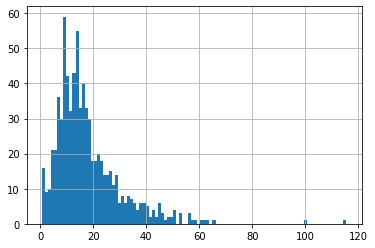

In [ ]:
avg_wait_time['wait_time'].hist(bins = 100);

У большей части операторов среднее время ответа не превышает 20 секунд. Но есть и очень длительное. 

Посчитаем сколько операторов неэффективны, если задать порог среднего времени ожидания в 20 секунд.

In [ ]:
inefficient_1 = avg_wait_time[avg_wait_time['wait_time'] > 20]
inefficient_1

,operator_id,wait_time
6,882476,31.67
7,882478,22.25
11,882688,42.65
12,882690,40.17
16,884408,28.01
...,...,...
745,970244,40.50
746,970252,25.00
747,970254,40.33
751,972412,25.00


У 229 операторов среднее время ответа выше 20 секунд. 

Будем считать это неэффективным. Возможно на линии не хватает операторов или сами операторы не торопятся снять трубку, в любом случае это нужная информация для наших клиентов. 

Также в дашборде можно предложить им опцию выбора среднего времени ожидания входящего звонка при котором оператор будет считаться неэффективным.

Для этого добавим среднее время ожидания в в основной датасет.

In [ ]:
tel = tel.merge(avg_wait_time, on=["operator_id"], how='left')
tel

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,tariff_plan,date_start,received,missed,percent_missed,wait_time
0,166377,2019-08-05,0,True,880022,True,3,0,5,B,2019-08-01,8.0,0.0,0.0,14.00
1,166377,2019-08-05,0,True,880020,True,1,0,1,B,2019-08-01,7.0,0.0,0.0,7.71
2,166377,2019-08-05,0,True,880020,False,1,10,18,B,2019-08-01,7.0,0.0,0.0,7.71
3,166377,2019-08-05,0,False,880022,True,3,0,25,B,2019-08-01,8.0,0.0,0.0,14.00
4,166377,2019-08-05,0,False,880020,False,2,3,29,B,2019-08-01,7.0,0.0,0.0,7.71
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41541,168606,2019-11-09,0,False,957922,False,4,551,593,C,2019-10-31,2.0,1.0,33.0,8.25
41542,168606,2019-11-10,0,True,957922,False,1,0,25,C,2019-10-31,2.0,1.0,33.0,8.25
41543,168606,2019-11-10,0,True,957922,True,1,0,38,C,2019-10-31,2.0,1.0,33.0,8.25
41544,168606,2019-11-11,0,True,957922,False,2,479,501,C,2019-10-31,2.0,1.0,33.0,8.25


### Изучим среднее количество обработанных исходящих вызовов

Есть разные мнения сколько звонков должен совершать оператор - на исходящей линии хороший продажник совершает в среднем от 100-120 звонков (зависит от средней длительности разговора по проекту) Источник: https://www.voiptime.net/ru/call-center-work-standarts_ru.html

Среднее кол-во звонков в день которое должен совершать оператор = 144
(18 звонков в час.) Источник: https://calldirect.ru/skolko-zvonkov-dolzhen-delat-operator-koll-czentra/

Изучим наши данные

Сформируем таблицу по операторам, которые специализируются на обзвонах

In [ ]:
oper_dir = pd.pivot_table(tel, index=['operator_id'],columns=['direction'],
               values=['calls_count'], aggfunc=['sum'],fill_value=0)

oper_dir['date'] = pd.pivot_table(tel, index=['operator_id'],
               values=['date'], aggfunc=['nunique'])

oper_dir.reset_index()

oper_dir.columns= [ 'out', 'in', 'days']
oper_dir['percent_out'] = round(oper_dir['out']/(oper_dir['out'] + oper_dir['in']) * 100)

oper_dir.head()

,out,in,days,percent_out
operator_id,,,,
879896,872,58,50,94.0
879898,7209,104,84,99.0
880020,38,7,14,84.0
880022,189,8,42,96.0
880026,2208,24,77,99.0


In [ ]:
oper_out = oper_dir.query('percent_out >=50')

In [ ]:
oper_out['avg_out'] = oper_out['out']/oper_out['days']
oper_out['avg_out'] = round (oper_out['avg_out'],2)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
oper_out.sort_values(by = 'avg_out' )

,out,in,days,percent_out,avg_out
operator_id,,,,,
930510,2,2,4,50.0,0.50
940610,1,1,2,50.0,0.50
954318,1,1,2,50.0,0.50
952196,2,2,3,50.0,0.67
896018,9,8,13,53.0,0.69
...,...,...,...,...,...
885876,58437,992,97,98.0,602.44
929428,23754,0,33,100.0,719.82
885890,58977,1244,80,98.0,737.21


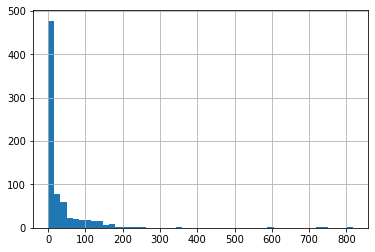

In [ ]:
oper_out['avg_out'].hist(bins = 50)

Мы видим по распределению, что у большей части операторов меньше 100 звонков в день. У половины операторов меньше 10 звонков в день. Возникают сомнения, что эти операторы специализируются на обзвоне, хотя доля исходящих у них более 50%, но количество звонков очень маленькое

In [ ]:
oper_out.query('avg_out < 10').count()

out            394
in             394
days           394
percent_out    394
avg_out        394
dtype: int64

In [ ]:
oper_out.query('avg_out > 100').count()

out            74
in             74
days           74
percent_out    74
avg_out        74
dtype: int64

Только у 74 операторов более 100 звонков в день

Этот признак неэффективности необходимо доработать прежде чем вносить в новую функциональность. Провести опрос среди действующих клиентов: специализируются ли они на обзвоне и существует ли норма по количеству исходящих вызовов для  операторов. 

### Изучим среднее время разговора по входящим звонкам

Также нашим клиентам можно предложить выявление неэффективных операторов, которые слишком долго обрабатывают входящие вызовы, значит, он недостаточно хорошо разбирается в продукте и ему приходится искать ответы на вопросы клиента. Кроме того, если беседа превышает стандартное время, собирается очередь звонков и рушатся другие важные показатели.

Параметр AHT: average handling time — время обработки обращения (Индустриальный стандарт АНТ — от 4 до 6 минут.) Источник https://www.cossa.ru/special/business-processes/276786/?ysclid=l4jt0sf2on196552777

Срез данных, в котором только входящие звонки у нас уже есть - operator_in Добавим в него колонку среднее время звонка (колонку call_duration разделить на колонку calls_count и разделить на 60, чтобы перевести в минуты)

In [ ]:
operator_in['aht'] = round((operator_in['call_duration']/operator_in['calls_count']/60),2)
operator_in.sample(5)

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,tariff_plan,date_start,wait_time,aht
38835,168252,2019-11-06,1,False,940616,False,25,2194,2406,A,2019-10-17,8.480000,1.46
5209,166582,2019-09-03,1,False,885890,False,24,1988,2196,A,2019-08-09,8.666667,1.38
32055,167888,2019-11-26,1,False,928888,False,7,1151,1208,C,2019-10-04,8.142857,2.74
17362,167071,2019-10-25,1,False,913942,False,31,2848,3204,B,2019-08-30,11.483871,1.53
39742,168315,2019-11-19,1,False,952734,False,7,1588,1595,B,2019-10-21,1.000000,3.78


Сгруппируем срез по операторам и рассчитаем среднее время разговора при входящих вызовах

In [ ]:
avg_aht = operator_in.groupby('operator_id').agg({'aht':'mean'}).reset_index()
avg_aht['aht'] = round(avg_aht['aht'],2)
avg_aht.head()

,operator_id,aht
0,879896,2.48
1,879898,1.09
2,880020,0.71
3,880022,1.07
4,880026,0.95


Изучим распределение среднего времени звонка


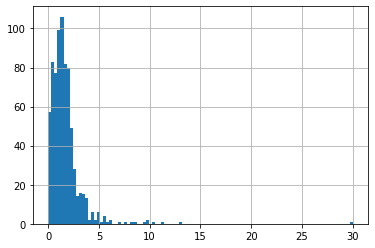

In [ ]:
avg_aht['aht'].hist(bins=100)

Среднее время разговора у большинства операторов менее 5 минут. Посчитаем сколько операторов разговаривают в среднем дольше.

In [ ]:
avg_aht.query('aht > 5').count()

operator_id    19
aht            19
dtype: int64

Всего 19 операторов разговаривают в среднем дольше 5 минут при вхдящих вызовах.

Чтобы отображать этот параметр в дашборде, добавим столбец средней продолжительности входящих звонков в основной датасет

In [ ]:
tel = tel.merge(avg_aht, on=["operator_id"], how='left')
tel.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,tariff_plan,date_start,received,missed,percent_missed,wait_time,aht
0,166377,2019-08-05,0,True,880022,True,3,0,5,B,2019-08-01,8.0,0.0,0.0,14.00,1.07
1,166377,2019-08-05,0,True,880020,True,1,0,1,B,2019-08-01,7.0,0.0,0.0,7.71,0.71
2,166377,2019-08-05,0,True,880020,False,1,10,18,B,2019-08-01,7.0,0.0,0.0,7.71,0.71
3,166377,2019-08-05,0,False,880022,True,3,0,25,B,2019-08-01,8.0,0.0,0.0,14.00,1.07
4,166377,2019-08-05,0,False,880020,False,2,3,29,B,2019-08-01,7.0,0.0,0.0,7.71,0.71


 ## Определить неэффективных операторов 

Мы выявили неэффективных операторов по 3 признакам, один у нас остался на будущее, решим нужен ли он клиентам после опроса. 

Чтобы знать к кому из клиентов в первую очередь обращаться с новой функциональностью, выявим у кого из клиентов больше всего неэффективных операторов.

Сделаем скоринговую систему. Будем начислять оператору по 1 баллу, если он попадает в принятые выше критерии

In [ ]:
tel['scoring'] = 0

Начислим 1 балл тем операторам, которые пропускают более 5% входящих звонков

In [ ]:
tel.loc[(tel.percent_missed > 5), 'scoring'] = 1

Начислим 1 балл операторам, у которых среднее время ожидания на входящей линии составляет более 20 секунд

In [ ]:
tel.loc[(tel.wait_time > 20), 'scoring'] = tel.scoring + 1

Начислим 1 балл операторам, у которых среднее время разговора с клиентами на входящей линии составляет более 5 минут

In [ ]:
tel.loc[(tel.aht > 5), 'scoring'] = tel.scoring + 1

Посмотрим сколько операторов у нас получили баллы за неэффективность по нескольким или одному критерию.

In [ ]:
tel['scoring'].value_counts()

0    31260
1     9260
2     1026
Name: scoring, dtype: int64

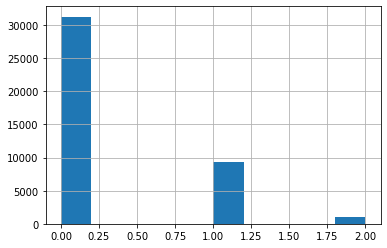

In [ ]:
tel['scoring'].hist()

Три балла не получил никто, есть операторы, у которых два балла и один. Выведем список с  ними.

In [ ]:
oper_id_2 = tel.query('scoring == 2')['operator_id'].unique()
oper_id_2

array([888532, 888538, 934076, 884408, 897872, 888406, 894120, 896538,
       900746, 899268, 899898, 911102, 911142, 905300, 926490, 920706,
       924936, 937368, 944220, 944226, 944218, 944222, 944216, 934098,
       958468, 958478, 948758])

In [ ]:
len(oper_id_2)

27

У нас 27 операторов, у которых 2 балла неэффективности.

In [ ]:
oper_id_1 = tel.query('scoring == 1')['operator_id'].unique()
oper_id_1

array([882476, 882478, 886892, 891900, 891906, 902510, 902532, 882688,
       882690, 939478, 888534, 888536, 907440, 887276, 887282, 907174,
       959312, 884412, 906680, 925106, 923254, 930510, 900194, 908834,
       908960, 908958, 910958, 946468, 893420, 886146, 892798, 890406,
       890412, 955436, 925808, 891744, 915614, 960296, 960294, 972412,
       890226, 890228, 891646, 899082, 891254, 891918, 894232, 909624,
       894224, 894230, 919994, 892530, 892538, 892536, 892532, 892534,
       893172, 901350, 910226, 913886, 919896, 930242, 894614, 895140,
       913474, 896536, 903512, 927070, 895776, 894656, 894662, 896018,
       895786, 895782, 906396, 906398, 906392, 906394, 906402, 906404,
       906400, 906408, 906410, 906406, 906412, 951332, 954750, 898560,
       898558, 899892, 899900, 899906, 901894, 909134, 900492, 901498,
       901492, 910516, 923528, 911140, 911152, 901038, 956484, 900792,
       922356, 920982, 902910, 907224, 907178, 951650, 905564, 928092,
      

In [ ]:
len(oper_id_1)

254

И 254 оператора, которые получили 1 балл неэффективности

Изучим к каким клиентам относятся эти операторы. У каких клиентов будет самый большой средний балл неэффективности операторов.

In [ ]:
user_scor = tel.groupby(['user_id']).agg({'scoring':'mean'})
user_scor.sort_values(by = 'scoring', ascending = False).head(15)


,scoring
user_id,
167162,2.000000
168004,2.000000
167977,2.000000
166669,2.000000
166619,2.000000
166975,1.757576
166946,1.276596
167172,1.133333
166879,1.095652


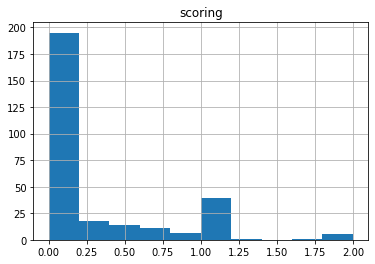

In [ ]:
user_scor.hist();

In [ ]:
user_scor[user_scor['scoring'] > 1].count()

scoring    11
dtype: int64

In [ ]:
user_scor[user_scor['scoring'] == 1].count()

scoring    35
dtype: int64

В первую очередь с новой функциональностью нужно обращаться к тем клиентам, у которых средний балл эффективности операторов больше 1, таких клиентов 11. Затем к тем у кого scoring = 1, таких клиентов 35.  

## Проверим статистические гипотезы

### Одинаковое ли среднее ожидание ответа при входящих звонках у клиентов на разных тарифах

 

Сформулируем нулевую гипотезу: среднее ожидание ответа при входящих звонках у клиентов на тарифах А, В, С одинаково
Альтернативная: гипотезу: среднее ожидание ответа при входящих звонках у клиентов на тарифах А, В, С разное

 - сделаем срез по входящим, не пропущенным звонкам, сгруппируем его по тарифам клиента 
  - выберем колонку с ожиданием и передадим ее данные по разным тарифам в ttest_ind
  - проверим стат гипотезу о равенстве среднего

In [ ]:
in_call = tel.query('direction == 1 and is_missed_call == False')

Выберем время ожидания для тарифа А, В, С

In [ ]:
tariff_A = in_call.query('tariff_plan == "A"')['wait_time']
tariff_A.head()

1754    26.44
1756    26.44
1763    28.24
1770    28.24
1772    28.24
Name: wait_time, dtype: float64

In [ ]:
tariff_B = in_call.query('tariff_plan == "B"')['wait_time']
tariff_B.head()

21    6.11
26    6.11
29    5.94
30    6.11
38    6.11
Name: wait_time, dtype: float64

In [ ]:
tariff_C = in_call.query('tariff_plan == "C"')['wait_time']
tariff_C.head()

482    31.67
483    22.25
484    22.25
486    31.67
487    31.67
Name: wait_time, dtype: float64

Так как мы будем проводить множественное сравнение, то внесем поправку Бонферрони. Разделим стандартное alpha = 0,05 на 3 (число проверок) 

In [ ]:
alpha = 0.017 

results = st.ttest_ind( tariff_A, tariff_B, equal_var=False)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  4.1435642238801275e-39
Отвергаем нулевую гипотезу


In [ ]:
alpha = 0.017

results = st.ttest_ind( tariff_A, tariff_C, equal_var=False)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  0.04037644542155919
Не получилось отвергнуть нулевую гипотезу


In [ ]:
alpha =  0.017 

results = st.ttest_ind( tariff_B, tariff_C, equal_var=False)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  1.5676995652092462e-40
Отвергаем нулевую гипотезу


При сравнении тарифа А и С не получилось отвергнуть нулевую гипотезу, т.е.  среднее ожидание ответа при входящих звонках у клиентов на тарифах А, С не имеет статистической разницы. 
При сравнении тарифов А и В, В и С нулевая гипотеза была отвергнута различия в среднем времени ожидания при входящих звонках между группами есть.

### Одинаковый ли процент пропущенных вызовов у клиентов на разных тарифах



Сделаем срез по входящим вызовам

In [ ]:
user_in = tel.query('direction == 1')

Сделаем сводную таблицу по разным тарифам

In [ ]:
user_in_tarif = user_in.pivot_table(index = 'tariff_plan',
                                   values = ('received','missed'),
                                   aggfunc = 'sum').reset_index()
user_in_tarif

#users_by_events.columns = ['event', '246', '247', '248']


,tariff_plan,missed,received
0,A,17362.0,1339976.0
1,B,16086.0,1525129.0
2,C,10013.0,1837859.0


Так как мы будем проводить множественное сравнение, то внесем поправку Бонферрони. Разделим стандартное alpha = 0,05 на 3 (число проверок) 

Напишем функцию для расчета p-value

In [ ]:
def ztest (successes_1, successes_2, trials_1, trials_2):
    successes = np.array([successes_1, successes_2])
    trials = np.array([trials_1, trials_2])
    
    # пропорция пропущенных в первой группе:
    p1 = successes[0]/trials[0]

  # пропорция пропущенных во второй группе:
    p2 = successes[1]/trials[1]
    
    # пропорция пропущенных в комбинированном датасете:
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

  # разница пропорций в датасетах
    difference = p1 - p2 
    
    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))
    
    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)  

    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    return p_value  

Напишем функцию, которая будет выводить результаты теста

In [ ]:
def print_result (p_value):
    
    alpha = 0.017 # критический уровень статистической значимости

    print('p-значение: ', p_value)

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между процентами пропущенных вызовов на разных тарифах значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными') 

In [ ]:
trials_A = user_in_tarif.loc[0,'missed'] + user_in_tarif.loc[0,'received']
successes_A = user_in_tarif.loc[0,'missed']
trials_A, successes_A


(1357338.0, 17362.0)

In [ ]:
trials_B = user_in_tarif.loc[1,'missed'] + user_in_tarif.loc[1,'received']
successes_B = user_in_tarif.loc[1,'missed']
trials_B, successes_B

(1541215.0, 16086.0)

In [ ]:
trials_C = user_in_tarif.loc[2,'missed'] + user_in_tarif.loc[2,'received']
successes_C = user_in_tarif.loc[2,'missed']
trials_C, successes_C

(1847872.0, 10013.0)

 Сформулируем нулевую гипотезу - процент пропущенных вызовов у клиентов на тарифах А и В одинаков.

In [ ]:
print_result(ztest(successes_A, successes_B, trials_A, trials_B))

p-значение:  0.0
Отвергаем нулевую гипотезу: между процентами пропущенных вызовов на разных тарифах значимая разница


In [ ]:
print_result(ztest(successes_C, successes_B, trials_C, trials_B))

p-значение:  0.0
Отвергаем нулевую гипотезу: между процентами пропущенных вызовов на разных тарифах значимая разница


In [ ]:
print_result(ztest(successes_A, successes_C, trials_A, trials_C))

p-значение:  0.0
Отвергаем нулевую гипотезу: между процентами пропущенных вызовов на разных тарифах значимая разница


In [ ]:
from statsmodels.stats.proportion import proportions_ztest
import numpy as np


alpha = 0.017

sample_success_a, sample_size_a = (successes_A, trials_A)  
sample_success_b, sample_size_b = (successes_B, trials_B)

successes = np.array([sample_success_a, sample_success_b])
samples = np.array([sample_size_a, sample_size_b])

# note, no need for a Ho value here - it's derived from the other parameters
stat, p_value = proportions_ztest(count=successes, nobs=samples,  alternative='two-sided')

# report
print('z_stat: %0.3f, p_value: %0.3f' % (stat, p_value))

if p_value > alpha:
   print ('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')
else:
   print ("Отвергаем нулевую гипотезу")


z_stat: 18.725, p_value: 0.000
Отвергаем нулевую гипотезу


## Выводы и рекомендации

 Для выявления неэффективных операторов были использованы индустриальные стандарты по эффективности операторов кол центров:
 - процент пропущенных вызовов не более 5
 - среднее время ожидание ответа - 20 секунд
 - среднее количество обработанных исходящих звонков - 100 в день (не учитывался, т.к. таких операторов очень мало)
 - среднее время разговора - не более 5 минут

 В итоге мы получили список операторов и кол-центров к которым они относятся, которые неэффективны по какому-то критерию

  27 операторов, у которых 2 балла неэффективности (2 критерия одновременно)

  254 оператора, которые получили 1 балл неэффективности


Выявили 11 клиентов у которых средний балл эффективности операторов больше 1. И 35 клиентов у которых средний балл эффективности операторов больше 1.

Предложения: обратится к этим клиентам (кол-центрам) с предложением отслеживать эфективность своих операторов в режиме реального времени, например, каждую неделю и по итогам сообщать операторам о результатах их работы и каких показателей от них ждут. Пообщрять самых эффективных, расставаться с теми, кто не хочет работать над своими показателями. 